# Developing a CNN for CIFAR-10 with PyTorch

This notebook guides you through the process of building, training, and evaluating a Convolutional Neural Network (CNN) on the CIFAR-10 dataset using PyTorch. CIFAR-10 is a standard dataset consisting of 60,000 32x32 color images in 10 different classes.

## Import Required Libraries

We'll start by importing PyTorch and other necessary libraries for working with CNNs and the CIFAR dataset.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## Load and Prepare CIFAR Dataset

We'll download and load the CIFAR-10 dataset using PyTorch's torchvision.datasets module. The CIFAR-10 dataset contains 50,000 training images and 10,000 test images across 10 classes:
- Airplane
- Automobile
- Bird
- Cat
- Deer
- Dog
- Frog
- Horse
- Ship
- Truck

In [2]:
# Directory to store the dataset
data_dir = './data'

# Download and load CIFAR-10 dataset
print("Downloading CIFAR-10 dataset...")

## Data Transformation and Augmentation

Data transformations and augmentations are crucial for improving model generalization. We'll apply:
1. Normalization: Scale pixel values to have zero mean and unit variance
2. Augmentations for training: Random crops and horizontal flips to increase diversity

In [3]:
# Define transforms for training data (with augmentation)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Define transforms for test data (no augmentation, only normalization)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load the datasets
trainset = torchvision.datasets.CIFAR10(
    root=data_dir, train=True, download=True, transform=transform_train
)

testset = torchvision.datasets.CIFAR10(
    root=data_dir, train=False, download=True, transform=transform_test
)

# Define class names for later visualization
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

## Create Data Loaders

PyTorch's DataLoader class provides an efficient way to batch, shuffle, and load data in parallel. We'll set up DataLoaders for both training and test datasets.

Batch shape: torch.Size([128, 3, 32, 32])
Labels shape: torch.Size([128])


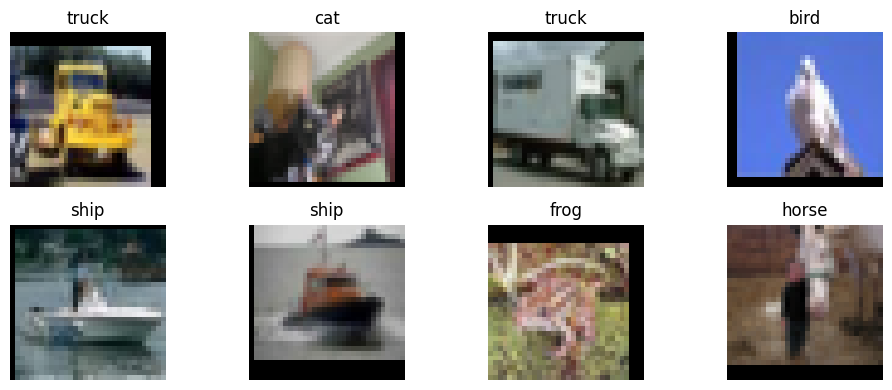

In [4]:
batch_size = 128

# Create data loaders
trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

testloader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

# Let's see the shape of our data
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

# Display some sample images
plt.figure(figsize=(10, 4))
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = images[i].numpy().transpose((1, 2, 0))
    # Unnormalize
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(classes[labels[i]])
    plt.axis('off')

plt.tight_layout()
plt.show()

## Define CNN Architecture

Now we'll define our CNN architecture using PyTorch's nn.Module. Our model consists of:
- Multiple convolutional layers with batch normalization
- MaxPooling layers for dimensionality reduction
- ReLU activations for non-linearity
- Dropout for regularization
- Fully connected layers for classification

In [5]:
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Fourth convolutional block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 10)
        
    def forward(self, x):
        # First block
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Second block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Third block
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Fourth block
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        # Flatten for fully connected layers
        x = x.view(-1, 256 * 2 * 2)
        
        # Fully connected layers with dropout
        x = self.dropout(F.relu(self.bn5(self.fc1(x))))
        x = self.fc2(x)
        
        return x

# Initialize the model and move it to the device
model = CIFAR10_CNN().to(device)
print(model)

CIFAR10_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_f

## Set Up Training Components

Here we'll define the necessary components for training our CNN model:
1. Loss function: Cross-Entropy Loss, suitable for multi-class classification
2. Optimizer: Adam optimizer for efficient gradient-based optimization
3. Learning rate scheduler: To reduce the learning rate during training

In [6]:
# Define loss function, optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total * 100

## Train the CNN Model

Now we'll implement the training loop. In each epoch, we:
1. Iterate through batches of training data
2. Forward pass through the model
3. Calculate the loss
4. Backward pass to compute gradients
5. Update model parameters
6. Track metrics like accuracy and loss

We'll also periodically evaluate the model on the validation set.

In [7]:
# Number of epochs to train
epochs = 20

# Lists to store metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training function
def train_epoch(model, trainloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    
    for inputs, labels in tqdm(trainloader, desc="Training"):
        # Move inputs and labels to device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        acc = calculate_accuracy(outputs, labels)
        
        # Update statistics
        running_loss += loss.item()
        running_acc += acc
    
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = running_acc / len(trainloader)
    
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, testloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc="Testing"):
            # Move inputs and labels to device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Calculate accuracy
            acc = calculate_accuracy(outputs, labels)
            
            # Update statistics
            running_loss += loss.item()
            running_acc += acc
    
    epoch_loss = running_loss / len(testloader)
    epoch_acc = running_acc / len(testloader)
    
    return epoch_loss, epoch_acc

# Training loop
start_time = time.time()

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    # Train for one epoch
    train_loss, train_acc = train_epoch(model, trainloader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Evaluate the model
    test_loss, test_acc = evaluate(model, testloader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # Update learning rate
    scheduler.step()
    
    # Print statistics
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print(f"Learning Rate: {scheduler.get_last_lr()[0]}")
    
    # Save the model if it's the best so far
    if test_acc == max(test_accuracies):
        torch.save(model.state_dict(), "cifar10_cnn_best.pt")
        print("Best model saved!")

# Calculate training time
end_time = time.time()
training_time = end_time - start_time
print(f"\nTraining completed in {training_time/60:.2f} minutes")


Epoch 1/20


Testing: 100%|██████████| 79/79 [00:08<00:00,  9.73it/s]


Train Loss: 1.2734, Train Acc: 54.09%
Test Loss: 1.0314, Test Acc: 63.49%
Learning Rate: 0.001
Best model saved!

Epoch 2/20


Testing: 100%|██████████| 79/79 [00:08<00:00,  9.28it/s]


Train Loss: 0.9228, Train Acc: 67.21%
Test Loss: 0.8697, Test Acc: 69.33%
Learning Rate: 0.001
Best model saved!

Epoch 3/20


Testing: 100%|██████████| 79/79 [00:08<00:00,  9.36it/s]


Train Loss: 0.7973, Train Acc: 72.02%
Test Loss: 0.7708, Test Acc: 73.11%
Learning Rate: 0.001
Best model saved!

Epoch 4/20


Training:  22%|██▏       | 85/391 [00:11<00:41,  7.38it/s]


KeyboardInterrupt: 

## Evaluate Model Performance

Now that we've trained the model, let's evaluate its performance on the test set and look at various metrics.

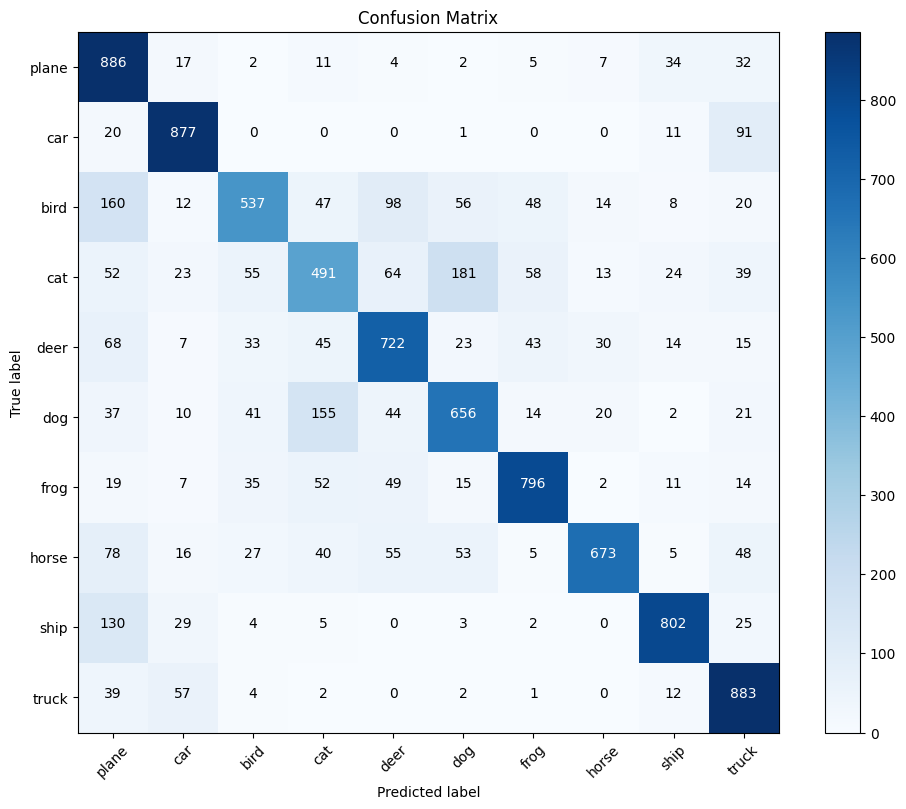

Classification Report:
              precision    recall  f1-score   support

       plane       0.60      0.89      0.71      1000
         car       0.83      0.88      0.85      1000
        bird       0.73      0.54      0.62      1000
         cat       0.58      0.49      0.53      1000
        deer       0.70      0.72      0.71      1000
         dog       0.66      0.66      0.66      1000
        frog       0.82      0.80      0.81      1000
       horse       0.89      0.67      0.77      1000
        ship       0.87      0.80      0.83      1000
       truck       0.74      0.88      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000

Overall Accuracy: 0.7323


In [8]:
# Load the best model
model.load_state_dict(torch.load("cifar10_cnn_best.pt"))

# Calculate confusion matrix
def get_all_preds(model, loader, device):
    all_preds = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

# Get predictions
y_pred, y_true = get_all_preds(model, testloader, device)

# Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add numbers to the cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Calculate overall accuracy
accuracy = np.sum(y_pred == y_true) / len(y_true)
print(f"Overall Accuracy: {accuracy:.4f}")

## Visualize Results

Let's visualize the training progress and examine some predictions on test images.

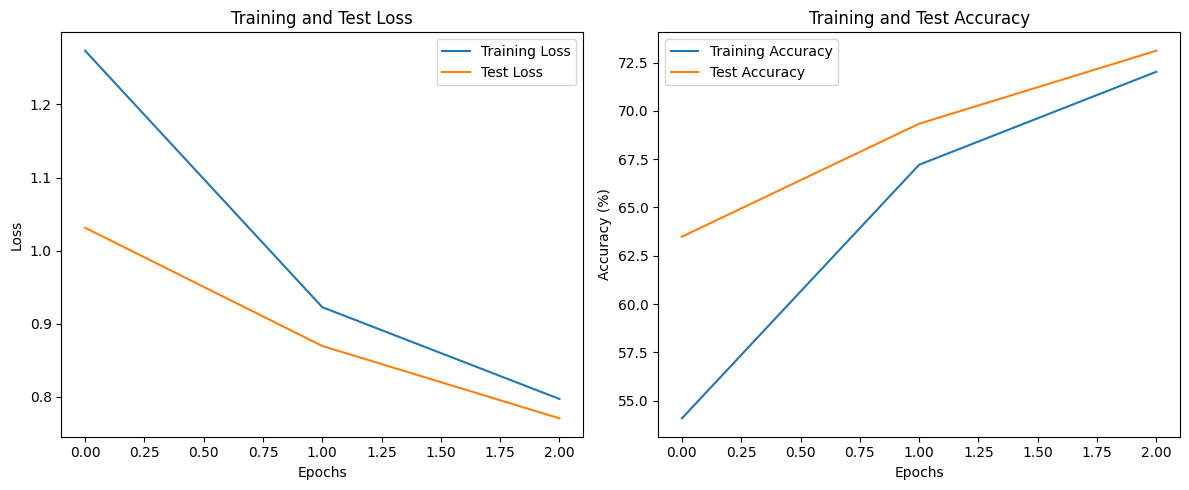

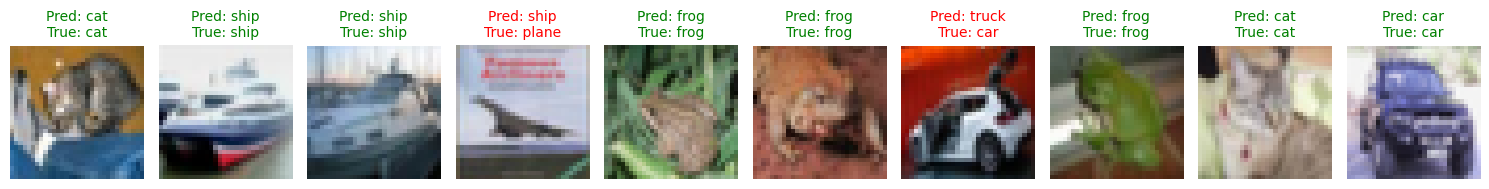

In [9]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize some predictions
def visualize_predictions(model, testloader, device, classes, n=10):
    # Get a batch of test images
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    
    # Make predictions
    images_device = images[:n].to(device)
    outputs = model(images_device)
    _, predicted = torch.max(outputs, 1)
    
    # Display images along with predictions
    plt.figure(figsize=(15, 3))
    
    for i in range(n):
        plt.subplot(1, n, i + 1)
        
        # Display image
        img = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2470, 0.2435, 0.2616])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        
        # Display prediction and ground truth
        color = 'green' if predicted[i] == labels[i] else 'red'
        plt.title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}", 
                  color=color, fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, testloader, device, classes, n=10)

## Save and Load the Model

Finally, let's demonstrate how to save and load our trained model for future use.

In [10]:
# The best model was already saved during training
# Here's how to load it and use it for inference

# Define a function to save the model
def save_model(model, filepath):
    """Save the model's state dictionary and architecture info"""
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': 'CIFAR10_CNN'
    }, filepath)
    print(f"Model saved to {filepath}")

# Define a function to load the model
def load_model(filepath, device):
    """Load a model from a checkpoint file"""
    # Load the saved data
    checkpoint = torch.load(filepath, map_location=device)
    
    # Create a new instance of the model architecture
    model = CIFAR10_CNN().to(device)
    
    # Load the state dictionary
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"Loaded model from {filepath}")
    return model

# Example of saving the model
save_model(model, "cifar10_cnn_final.pt")

# Example of loading the model
loaded_model = load_model("cifar10_cnn_final.pt", device)

# Quick test to ensure the loaded model works
loaded_model.eval()
with torch.no_grad():
    # Get one batch of test data
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    # Make predictions
    outputs = loaded_model(images)
    _, predicted = torch.max(outputs, 1)
    
    # Calculate accuracy for this batch
    accuracy = (predicted == labels).sum().item() / len(labels)
    print(f"Loaded model accuracy on a batch: {accuracy:.4f}")

# Example of using the model for inference on a single image
def predict_single_image(model, image_tensor, device, classes):
    model.eval()
    with torch.no_grad():
        # Add batch dimension and send to device
        image_tensor = image_tensor.unsqueeze(0).to(device)
        
        # Get prediction
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        
        # Get probability distribution
        probabilities = F.softmax(output, dim=1)[0]
        
        return {
            'class': classes[predicted.item()],
            'class_index': predicted.item(),
            'probabilities': {classes[i]: float(probabilities[i]) for i in range(len(classes))}
        }

# Get a test image
test_image, test_label = testset[0]
result = predict_single_image(loaded_model, test_image, device, classes)

print(f"True class: {classes[test_label]}")
print(f"Predicted class: {result['class']}")
print("Probabilities:")
for class_name, prob in result['probabilities'].items():
    print(f"  {class_name}: {prob:.4f}")

Model saved to cifar10_cnn_final.pt
Loaded model from cifar10_cnn_final.pt
Loaded model accuracy on a batch: 0.7656
True class: cat
Predicted class: cat
Probabilities:
  plane: 0.0341
  car: 0.0019
  bird: 0.0147
  cat: 0.5865
  deer: 0.0032
  dog: 0.1135
  frog: 0.0190
  horse: 0.0024
  ship: 0.2168
  truck: 0.0078


## Conclusion

In this notebook, we've:
1. Loaded and prepared the CIFAR-10 dataset
2. Applied data transformations and augmentations
3. Built a CNN architecture using PyTorch
4. Trained the model with optimization techniques
5. Evaluated the model's performance
6. Visualized results and predictions
7. Saved and loaded the model for future use

The techniques demonstrated here can be applied to other image classification tasks by adapting the architecture, hyperparameters, and data preprocessing steps to suit the specific dataset and problem.